# Survival Analysis applied to Credit Card fraud 
> A "gist" for survival analysis combining techniques from multiple sources

- toc: true
- branch: master
- badges: true
- comments: false
- author: Nazir Kamaldin
- categories: [python, survival analysis, oversampling]

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

from pycox.models import CoxTime
from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

# Neural network using pytorch
import torch
from torch import nn
import torch.nn.functional as F
import torchtuples as tt

import matplotlib.pyplot as plt

random_state = 7
np.random.seed(1234)
_ = torch.manual_seed(123)

The dataset that I'll be working on is taken from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). Since, the features of the dataset are a result of PCA, there's not much in terms of EDA we can do. 

In [2]:
# Read dataset

df = pd.read_parquet("./datasets/creditcard.parquet")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Given its a case of credit card fraud, its highly likely that labels are imbalanced, let's check for that.

In [3]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Clearly the positive class which represents fraud examples is clearly lacking. Here we will be using novelty detection to take advantage of the number of negative examples.

## Dataset split

In [4]:
V_columns = [col for col in df.columns if col.startswith("V")]
feature_columns = V_columns + ["Amount"]
label_column = "Class"
duration_column = "Time"

X = df[feature_columns]
y = df[label_column]
d = df[duration_column]

negative_indices = y[y == 0].index
positive_indices = y[y == 1].index

# X_neg = X.iloc[negative_indices, :]
# y_neg = y.iloc[negative_indices]
# d_neg = d.iloc[negative_indices]

X_train, X_test, y_train, y_test, d_train, d_test = train_test_split(X, y, d, test_size=0.2, stratify=y, random_state=random_state)
X_train, X_val, y_train, y_val, d_train, d_val = train_test_split(X_train, y_train, d_train, test_size=0.3, stratify=y_train, random_state=random_state)

print(f"Dataset sizes, X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}")

Dataset sizes, X_train: 159491, X_val: 68354, X_test: 56962


## Feature transformation

Create transformation function list for each column. Here since PCA has prepared the V* columns, only the "Amount" column requires processing. Here a standard scaler is applied.

In [5]:
standardize = [(["Amount"], StandardScaler())]
untouch = [(col, None) for col in V_columns]

X_mapper = DataFrameMapper(untouch + standardize)

The transformers are fitted to the training set and applied to the other datasets to avoid leakage.

In [6]:
X_train_transformed = X_mapper.fit_transform(X_train).astype('float32')
X_val_transformed = X_mapper.transform(X_val).astype('float32')
X_test_transformed = X_mapper.transform(X_test).astype('float32')

In [8]:
num_durations = 100
label_transformer = LogisticHazard.label_transform(num_durations)

y_train_surv = label_transformer.fit_transform(d_train.to_numpy(), y_train.to_numpy())
y_val_surv = label_transformer.transform(d_val.to_numpy(), y_val.to_numpy())

train = tt.tuplefy(X_train_transformed, (y_train_surv, X_train_transformed))
val = tt.tuplefy(X_val_transformed, (y_val_surv, X_val_transformed))

In [9]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, encoded_features),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, in_features),
        )
        self.surv_net = nn.Sequential(
            nn.Linear(encoded_features, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.surv_net(encoded)
        return phi, decoded

    def predict(self, input):
        # Will be used by model.predict later.
        # As this only has the survival output, 
        # we don't have to change LogisticHazard.
        encoded = self.encoder(input)
        return self.surv_net(encoded)


class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), 'Need `alpha` in [0, 1].'
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()
        
    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae

In [10]:
in_features = X_train.shape[1]
encoded_features = 4
out_features = label_transformer.out_features
net = NetAESurv(in_features, encoded_features, out_features)
loss = LossAELogHaz(0.6)

In [11]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=label_transformer.cuts, loss=loss)

In [12]:
dl = model.make_dataloader(train, batch_size=5, shuffle=False)
batch = next(iter(dl))

In [13]:
batch.shapes()

(torch.Size([5, 29]),
 ((torch.Size([5]), torch.Size([5])), torch.Size([5, 29])))

In [14]:
batch.levels


(0, ((2, 2), 1))

In [15]:
model.compute_metrics(batch)


{'loss': tensor(19.5352, device='cuda:0', grad_fn=<AddBackward0>)}

In [16]:
metrics = dict(
    loss_surv = LossAELogHaz(1),
    loss_ae   = LossAELogHaz(0)
)
callbacks = [tt.cb.EarlyStopping()]

In [17]:
batch_size = 256
epochs = 100
log = model.fit(*train, batch_size, epochs, callbacks, False, val_data=val, metrics=metrics)

In [18]:
res = model.log.to_pandas()
res.head()

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
0,0.688970,0.662828,0.728184,0.250631,0.016225,0.602240
1,0.213856,0.011752,0.517013,0.187087,0.013980,0.446747
2,0.187372,0.012158,0.450193,0.173133,0.012733,0.413732
3,0.176770,0.011448,0.424754,0.172909,0.011968,0.414320
4,0.172855,0.011461,0.414946,0.162235,0.012336,0.387083


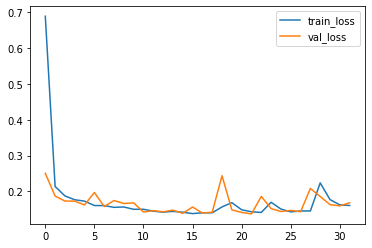

In [19]:
_ = res[['train_loss', 'val_loss']].plot()

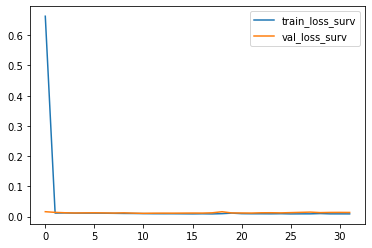

In [20]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

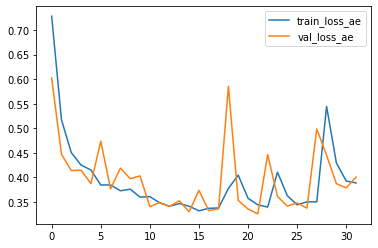

In [21]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

In [22]:
surv = model.interpolate(20).predict_surv_df(X_test_transformed)

Positive class: [452, 545, 821, 3244, 3246], Negative class: [0, 1, 2, 3, 4]


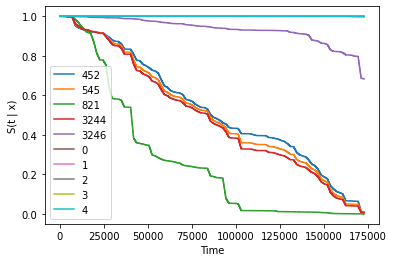

In [44]:
y_test_rst = y_test.reset_index(drop=True)
pos_test = list(y_test_rst[y_test_rst == 1].index[:5])
neg_test = list(y_test_rst[y_test_rst == 0].index[:5])
print(f"Positive class: {pos_test}, Negative class: {neg_test}")

surv.iloc[:, pos_test+neg_test].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [35]:
ev = EvalSurv(surv.astype('float32'), d_test.to_numpy().astype('float32'), y_test.to_numpy().astype('float32'), censor_surv='km')
ev.concordance_td('antolini')

0.9562779356451997

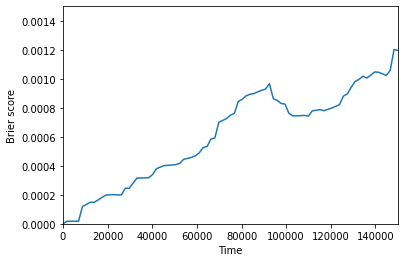

In [51]:
#hide
time_grid = np.linspace(d_test.min(), d_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
plt.xlim(0, 150000)
plt.ylim(0, 0.00150)
_ = plt.xlabel('Time')

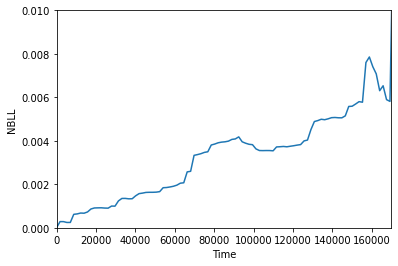

In [52]:
#hide
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
plt.xlim(0, 170000)
plt.ylim(0, 0.01)
_ = plt.xlabel('Time')